# DS 340W Mid Term Project

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the dataset
utah_data = pd.read_csv('0-2017-yearly.csv')

# 1. Calculate an alternative Drought Intensity Index (DII)
# DII = weighted sum of drought categories, with higher weights for more severe categories
utah_data['DII'] = (utah_data['D0'] * 0.2 + utah_data['D1'] * 0.4 +
                    utah_data['D2'] * 0.6 + utah_data['D3'] * 0.8 +
                    utah_data['D4'] * 1.0)

# Set a threshold for high drought risk (e.g., DII top 30%)
threshold = utah_data['DII'].quantile(0.7)
utah_data['Drought_Risk'] = np.where(utah_data['DII'] >= threshold, 1, 0)

# Prepare feature set (X) and target variable (y)
features = ['D0', 'D1', 'D2', 'D3', 'D4', 'W0', 'W1', 'SCORE', 'NA_COUNT']
X = utah_data[features]
y = utah_data['Drought_Risk']

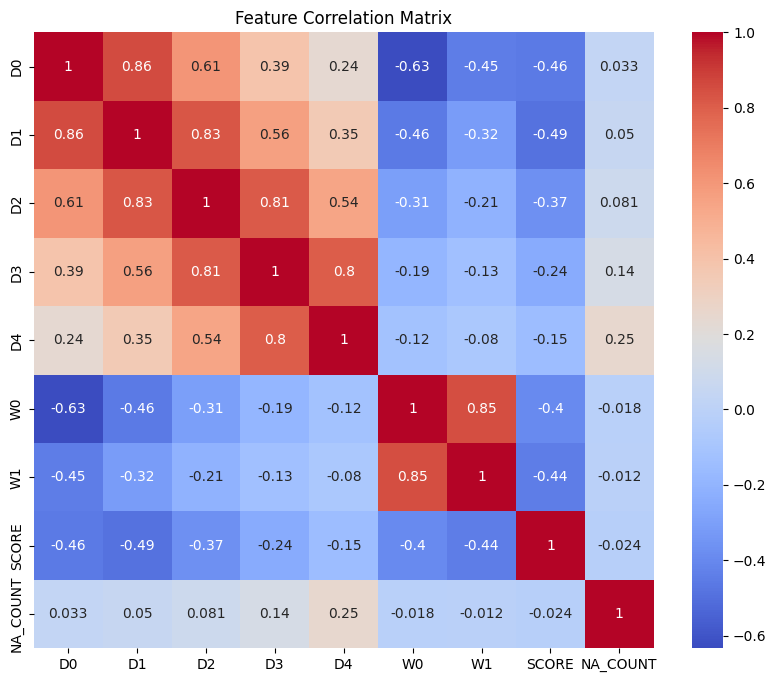

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': [50, 75, 100]},
             scoring='f1', verbose=2)

In [4]:
# Split data into train, validation, and test sets (60-20-20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply Lasso or Ridge for feature selection based on correlation
correlation_matrix = utah_data[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Choose Ridge if there is high correlation; otherwise, use Lasso
if correlation_matrix.abs().values.mean() > 0.3:
    selector = SelectFromModel(Ridge(alpha=1.0))
else:
    selector = SelectFromModel(Lasso(alpha=0.1))

selector.fit(X_train_scaled, y_train)

# Transform the data based on selected features
X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

# Define Random Forest model with stricter hyperparameter tuning
param_grid_rf = {
    'n_estimators': [50, 75, 100],
    'max_depth': [2, 3, 5],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [5, 10, 15]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf,
                              cv=StratifiedKFold(n_splits=5), scoring='f1', n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train_selected, y_train)



In [5]:
# Best model selection based on validation set results
best_rf_model = grid_search_rf.best_estimator_
y_val_pred_rf = best_rf_model.predict(X_val_selected)

# Calculate validation accuracy and F1 score
val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
val_f1_rf = f1_score(y_val, y_val_pred_rf)

# Display Drought Intensity Index (DII) summary and model performance
print("Drought Intensity Index (DII) Summary:")
print(" - Mean DII:", utah_data['DII'].mean())
print(" - Standard Deviation DII:", utah_data['DII'].std())
print(" - Proportion of High Drought Risk:", utah_data['Drought_Risk'].mean())

print("\nRandom Forest with Best Parameters from Grid Search:", grid_search_rf.best_params_)
print(f" - Validation Accuracy: {val_accuracy_rf}")
print(f" - Validation F1 Score: {val_f1_rf}")

# Final testing on test data if the validation results are below 85%
if val_accuracy_rf < 0.85:
    y_test_pred_rf = best_rf_model.predict(X_test_selected)
    test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
    test_f1_rf = f1_score(y_test, y_test_pred_rf)

    print(f"\nTest Accuracy for Random Forest: {test_accuracy_rf}")
    print(f"Test F1 Score for Random Forest: {test_f1_rf}")
else:
    print("Validation accuracy exceeds threshold, model may still overfit.")


Drought Intensity Index (DII) Summary:
 - Mean DII: 23.597661050545096
 - Standard Deviation DII: 45.852196539493875
 - Proportion of High Drought Risk: 0.3002973240832507

Random Forest with Best Parameters from Grid Search: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}
 - Validation Accuracy: 0.9900990099009901
 - Validation F1 Score: 0.9833333333333333
Validation accuracy exceeds threshold, model may still overfit.
